#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Откроем файл и запишем датасет в переменную data
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# Посмотрим первые 10 строк датафрейма data
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
# Выведем общую информацию о датафрейме data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Выведем количество пропущенных значений
data.isnull().sum()

num_orders    0
dtype: int64

In [6]:
# Отсортируем и проверим монотонность
data.sort_index(inplace=True)
data.index.is_monotonic

/var/folders/dv/l6g_wqw12qz5z1bwggntt7hm0000gn/T/ipykernel_41425/1751412301.py:3: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  data.index.is_monotonic


True

In [7]:
# Ресемплирование
data = data.resample('1H').sum()

In [8]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


***Вывод:***

Датасет содержит 26496 записей. Данные за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00, пропузенных значений нет. Выполнена сортировка по индексу, проверена монотонность, проведено ресемплирование, построена гистограмма.

## Анализ

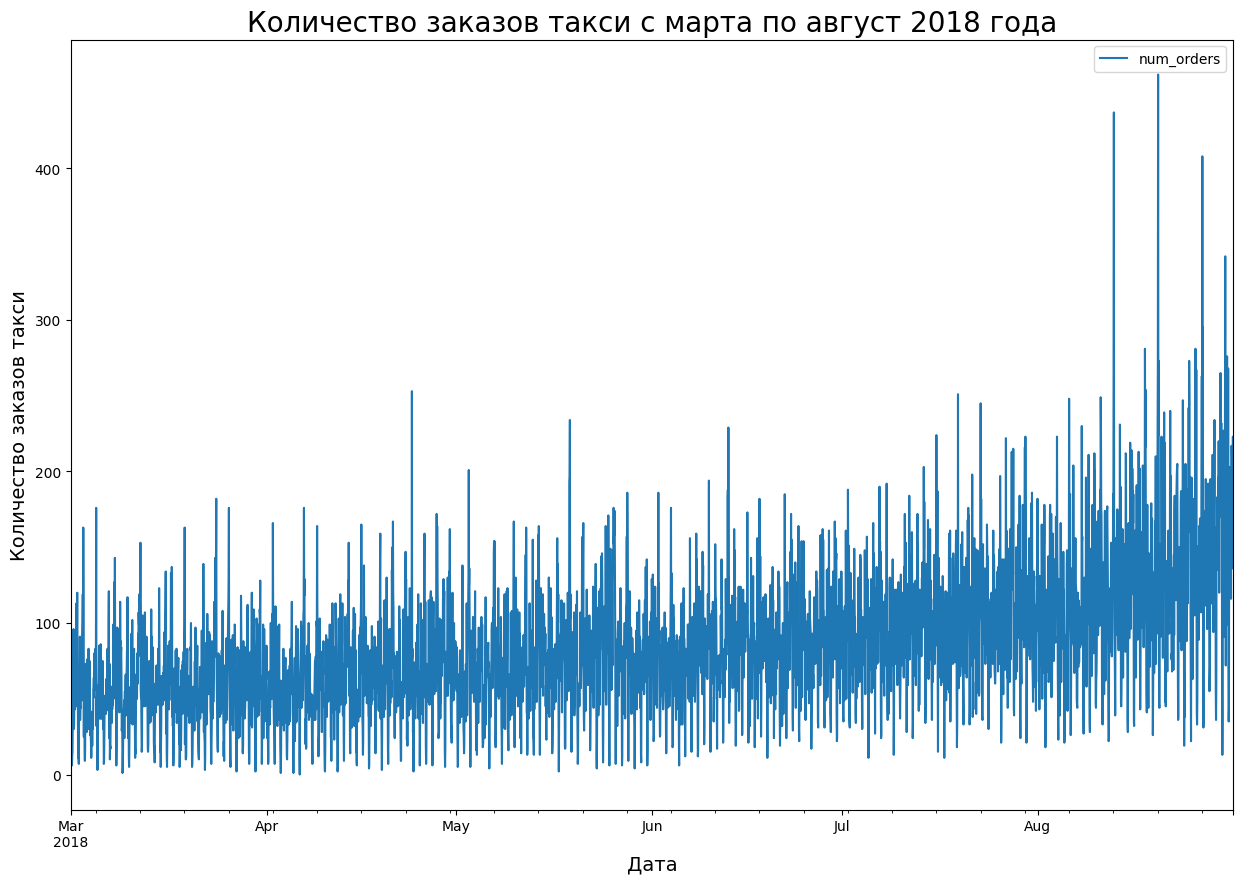

In [9]:
# График временного ряда
data.plot(figsize=(15,10))
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.title('Количество заказов такси с марта по август 2018 года', fontsize=20)
plt.legend()
plt.show()

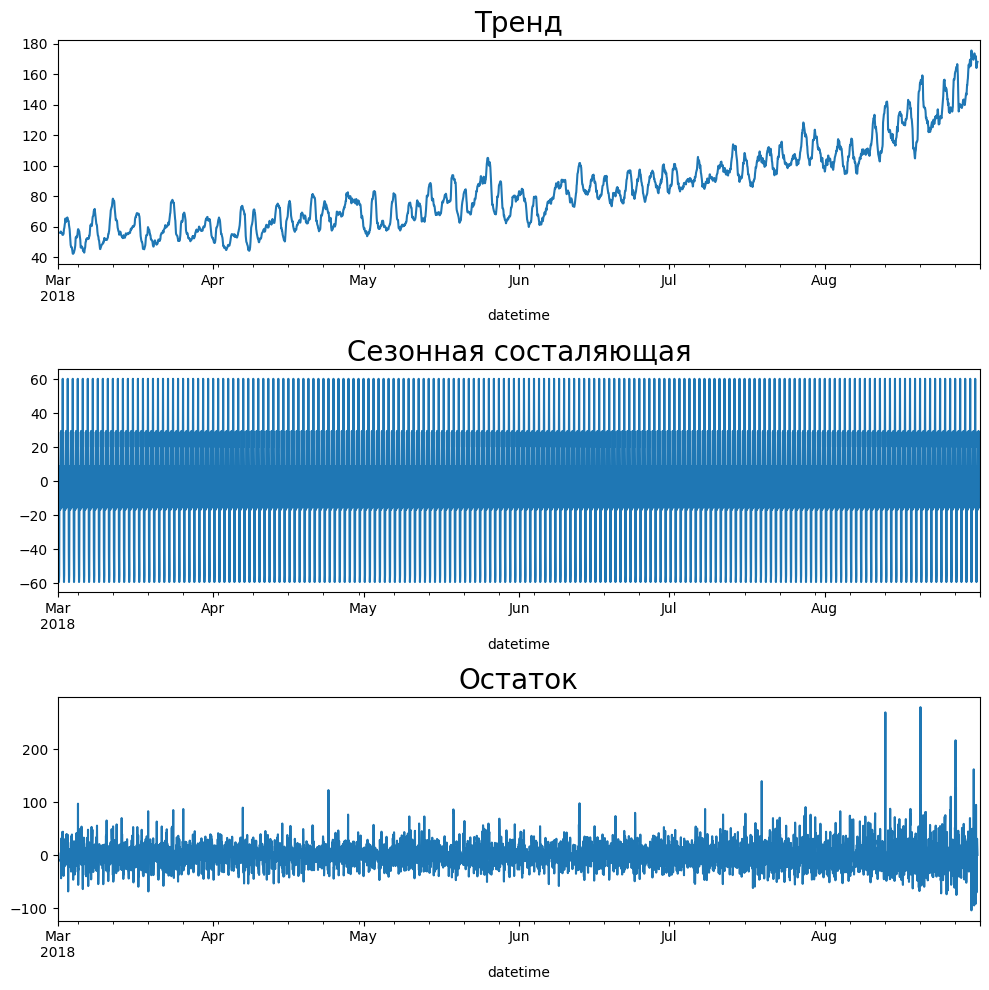

In [10]:
# Разложим временной ряд (весь период)
decomposed = seasonal_decompose(data)
 
plt.figure(figsize=(10, 10)) 
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд', fontsize=20)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная состаляющая', fontsize=20)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток', fontsize=20)
plt.tight_layout()

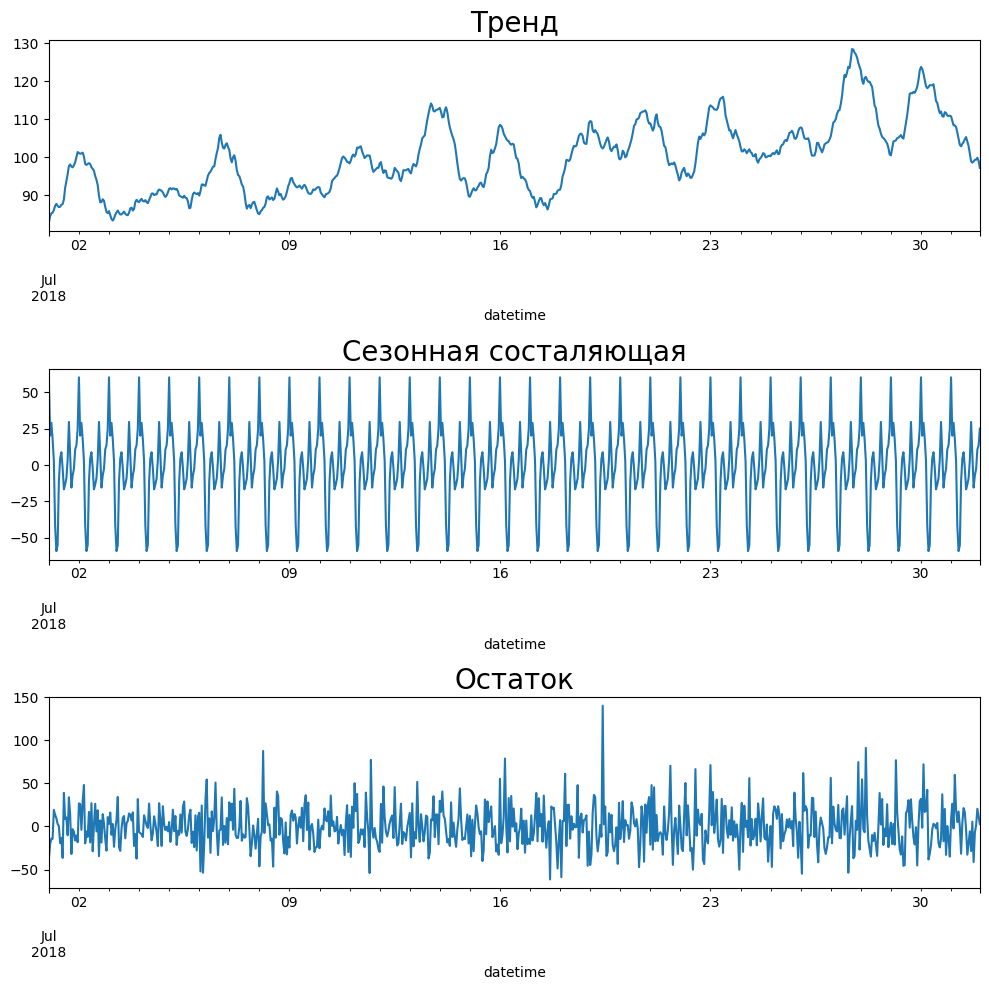

In [11]:
# Разложим временной ряд (месяц)
decomposed = seasonal_decompose(data)
 
plt.figure(figsize=(10, 10)) 
plt.subplot(311)
decomposed.trend['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Тренд', fontsize=20)
plt.subplot(312)
decomposed.seasonal['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Сезонная состаляющая', fontsize=20)
plt.subplot(313)
decomposed.resid['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Остаток', fontsize=20)
plt.tight_layout()

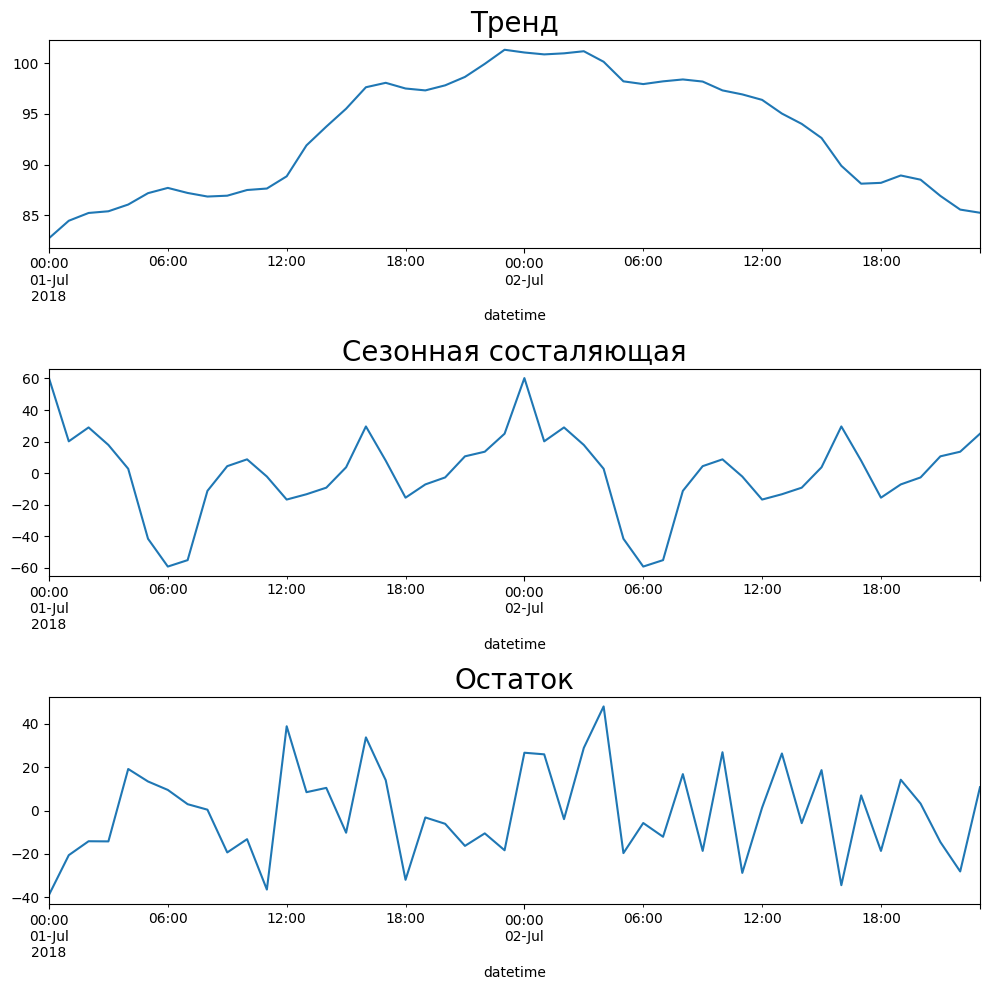

In [12]:
# Разложим временной ряд (два дня)
decomposed = seasonal_decompose(data)
 
plt.figure(figsize=(10, 10)) 
plt.subplot(311)
decomposed.trend['2018-07-01':'2018-07-02'].plot(ax=plt.gca())
plt.title('Тренд', fontsize=20)
plt.subplot(312)
decomposed.seasonal['2018-07-01':'2018-07-02'].plot(ax=plt.gca())
plt.title('Сезонная состаляющая', fontsize=20)
plt.subplot(313)
decomposed.resid['2018-07-01':'2018-07-02'].plot(ax=plt.gca())
plt.title('Остаток', fontsize=20)
plt.tight_layout()

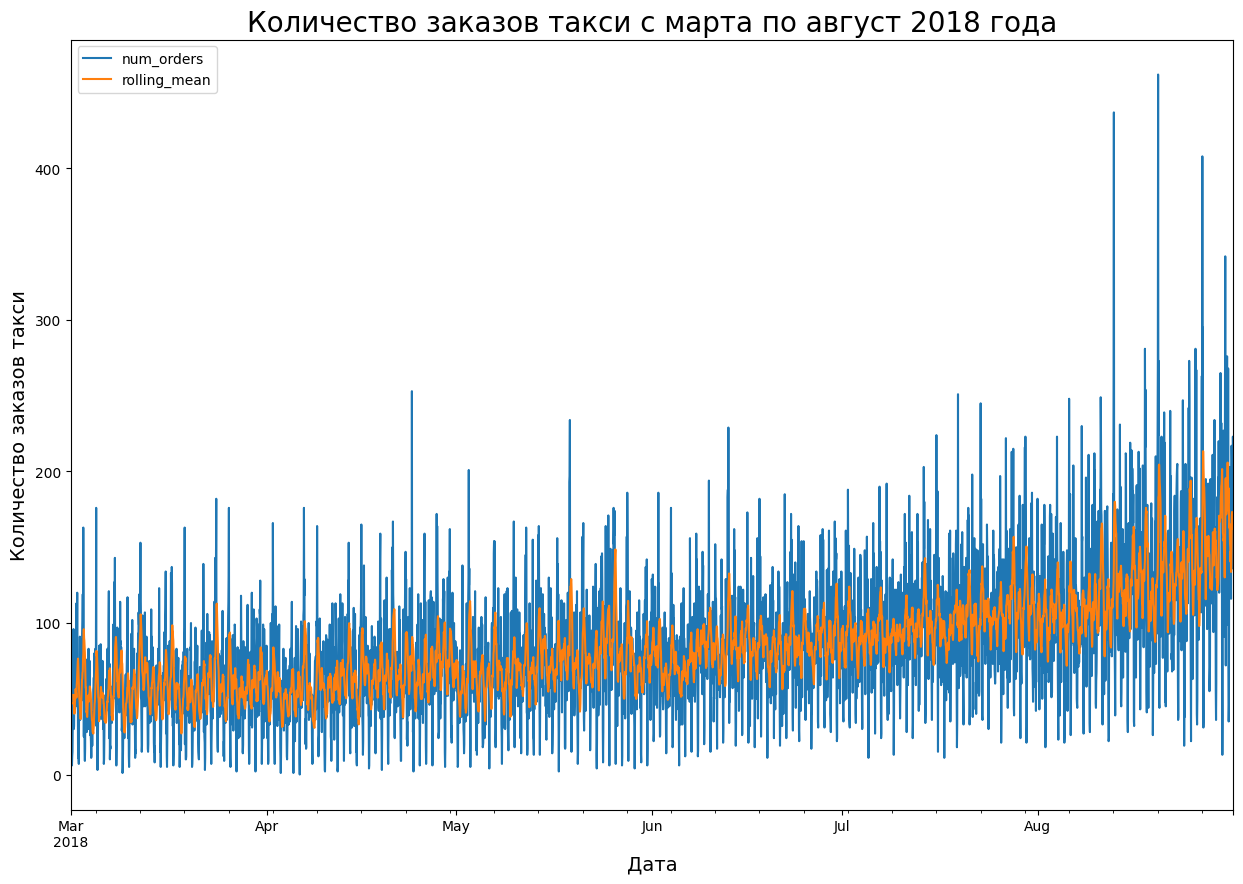

In [13]:
# Проверим стационарность ряда
data_new = data
data_new['rolling_mean'] =data_new.rolling(10, closed='left').mean()
data_new.plot(figsize=(15,10))
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.title('Количество заказов такси с марта по август 2018 года', fontsize=20)
plt.legend()
plt.show()

In [14]:
# Проверим стационарность ряда (Попробую другим способом из вашей рекоммендации)
result = adfuller(data['num_orders'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical values:')
for key, value in result[4].items():
  print('\t {}: {}'.format(key, value))

ADF Statistic: -3.0689242890279522
p-value: 0.0289400514026132
Critical values:
	 1%: -3.431842162413052
	 5%: -2.8621993540813637
	 10%: -2.567120978470452


Так как p-value меньше порогового значения 0.05, значит мы может отвергнуть нулевую гипотезу, что ряд нестационарный, а значит он стационарный.

In [15]:
# Функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
make_features(data, 24, 10)
data.head()

,num_orders,rolling_mean,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Удалим пропуски
data.dropna(inplace=True)

In [18]:
data.head()

,num_orders,rolling_mean,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,61.7,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,65.9,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,71.3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,74.5,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,76.5,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


***Вывод:***

Проанализированы графики временного ряда по всем данным, по месяцу и по 2 дням. Выявлен тренд на увеличение количества заказов с течением времени. Колебания внутри дня обусловлены тем, что большинство вылетов приходится на утренние, вечерние и ночные часы, днем вылеты тоже есть, но их гораздо меньше.

Временной ряд нестационарный, так как скользящее среднее увеличивается с течением времени.

Созданы календарные признаки для месяца, дня, дня недели и часа, отстающие признаки, скользящее среднее. Удалены пропуски.

## Обучение

In [19]:
# Разделим выборку на обучающую и x
train,x = train_test_split(data, shuffle = False, random_state = 12345, test_size = 0.2)

# Разделим выборку на валидационную и тестовую
valid, test = train_test_split(x, shuffle = False, random_state = 12345, test_size = 0.5)

# Получили: обучающая - 80%, валидационная - 10%, тестовая - 10%

In [20]:
# Проверим соотношение выборок
print(train.shape)
print(valid.shape)
print(test.shape)

(3513, 28)
(439, 28)
(440, 28)


In [21]:
# Выделим признаки
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [22]:
%%time
# Линейная регрессия
model = LinearRegression()
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions_valid)**0.5
print('RMSE для линейной регрессии:', rmse)

RMSE для линейной регрессии: 34.310075596597464
CPU times: user 9.29 ms, sys: 4.68 ms, total: 14 ms
Wall time: 10.3 ms


In [23]:
%%time
# Случайный лес
# Создадим переменные для лучших гиперпараметров
best_parametrs = []
best_rmse = 1000

# В цикле последовательно меняем гиперпараметры
for n_estimators in [100, 500, 1000]:
    for max_depth in range(2,7,2):         
        # Подставим гиперпараметры в модель
        model = RandomForestRegressor(random_state=12345,
                                      n_estimators=n_estimators,
                                      max_depth=max_depth)
                    
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predictions_valid)**0.5
                    
        # Сохранение лучших гиперпараметров
        if rmse < best_rmse:
            best_parametrs = [n_estimators, max_depth]
            best_rmse = rmse
                        
# Вывод лучших параметров
print('''RMSE случайного леса {}
Параметры модели:
   n_estimators = {}
   max_depth = {}'''.format(best_rmse,
                            best_parametrs[0],
                            best_parametrs[1]))                 

RMSE случайного леса 35.81592710846301
Параметры модели:
   n_estimators = 1000
   max_depth = 6
CPU times: user 59.9 s, sys: 660 ms, total: 1min
Wall time: 1min 2s


In [24]:
%%time
# LightGMB
model = LGBMRegressor(random_state=12345)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions_valid)**0.5
print('RMSE для LightGMB:', rmse)

RMSE для LightGMB: 32.916748868544644
CPU times: user 463 ms, sys: 26.9 ms, total: 490 ms
Wall time: 388 ms


***Вывод:*** 

Обучены модели: линейная регрессия, дерево решений, LightGBM. Сделаны предсказания, рассчитаны значения RMSE.
Наилучшая модель по скорости работы и по метрике - LinearRegression().

## Тестирование

In [25]:
%%time
# Линейная регрессия
model = LinearRegression()
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print('RMSE для линейной регрессии:', rmse)

RMSE для линейной регрессии: 45.380342806130784
CPU times: user 15.9 ms, sys: 3.93 ms, total: 19.9 ms
Wall time: 11.2 ms


In [26]:
%%time
# Проверка на адекватность
model = DummyRegressor()
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print('RMSE для DummyRegressor:', rmse)

RMSE для DummyRegressor: 87.63978988361437
CPU times: user 3.96 ms, sys: 1.78 ms, total: 5.74 ms
Wall time: 1.75 ms


***Вывод:***

Датасет содержит 26496 записей. Данные за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00, пропущенных значений нет. Выполнена сортировка по индексу, проверена монотонность, проведено ресемплирование, построена гистограмма.

Проанализированы графики временного ряда по всем данным, по месяцу и по 2 дням. Выявилен тренд на увеличение количества заказов с течением времени, а также тренд на то, что максимум заказов приходится на 12 ночи, а минимум на 6 утра. Временной ряд стационарный. Созданы календарные признаки для месяца, дня, дня недели и часа, отстающие признаки, скользящее среднее. Удалены пропуски.

Обучены модели: линейная регрессия, случайный лес, LightGBM. Сделаны предсказания, рассчитаны значения RMSE.

Наилучшая модель - LinearRegression:
 * Время работы - 140ms
 * RMSE - 34.31082470425057

RMSE для LinearRegression на тестовой выборке: 45.38103990832728

Выполнена проверка на адекватность, модель адекватна.